# Libraries

In [1]:
import heapq
import copy
import itertools

# All Definitions

In [2]:
# Function to initialize grid

def initialize_grid(n, m, obstacle_positions):

    # Initialize the grid with all cells as free (0)
    grid = [[0] * m for _ in range(n)]

    # Mark obstacle cells as blocked (1)
    for obstacle in obstacle_positions:
        x, y = obstacle
        grid[x][y] = 1

    return grid

In [3]:
# Defining class RobotState for states of robot
class RobotState:
    def __init__(self, position, picked_up_item=-1, delivered=False, time=0):
        self.position = position
        self.picked_up_item = picked_up_item
        self.delivered = delivered
        self.time = time

    def __eq__(self, other):
        return (
            self.position == other.position and
            self.picked_up_item == other.picked_up_item and
            self.delivered == other.delivered
        )

    def __hash__(self):
        return hash((self.position, self.picked_up_item, self.delivered, self.time))

    def __lt__(self, other):
      return True

    def __le__(self, other):
      return False

# Defining class for robot movement within the grid
class RobotAction:
    MOVE_UP = (-1, 0)
    MOVE_DOWN = (1, 0)
    MOVE_LEFT = (0, -1)
    MOVE_RIGHT = (0, 1)
    STAY_PUT = (0,0)

# Low level search with Manhattan distance heuristic

def low_level_search(grid, start_state, goal_state, item_pickup_locations, delivery_locations, constraints = []):
    def heuristic(current_state, goal_state):
        # Updated heuristic: Manhattan distance, considering time as cost (t=1 per step)
        return (
            abs(current_state.position[0] - goal_state.position[0]) +
            abs(current_state.position[1] - goal_state.position[1]) +
            current_state.time
        )


    open_set = [(0, start_state)]
    g_score = {start_state: 0}
    came_from = {}
    visited = []

    while open_set:
        f, current_state = heapq.heappop(open_set)

        if current_state.position == goal_state.position and current_state.delivered:
            # Reconstruct the path

            path = []
            item_index = current_state.picked_up_item
            while current_state in came_from:
                path.append(current_state.position)
                current_state = came_from[current_state]
            path.append(start_state.position)
            path.reverse()
            return path, item_index


        for action in [RobotAction.MOVE_UP, RobotAction.MOVE_DOWN, RobotAction.MOVE_LEFT, RobotAction.MOVE_RIGHT, RobotAction.STAY_PUT]:
            new_x = current_state.position[0] + action[0]
            new_y = current_state.position[1] + action[1]
            new_position = (new_x, new_y)

            if (
                0 <= new_x < len(grid)
                and 0 <= new_y < len(grid[0])
                and grid[new_x][new_y] == 0
            ):

                if new_position in item_pickup_locations and not current_state.delivered and current_state.picked_up_item == -1:
                        # Robot is over a pickup location and hasn't delivered or picked up an item.
                        # Create two states: one where it picks up and one where it doesn't.
                        new_state = RobotState(new_position, picked_up_item=item_pickup_locations.index(new_position), time=current_state.time+1)
                        # g_score[new_state] = g_score[current_state]

                elif current_state.picked_up_item != -1 and new_position == delivery_locations[current_state.picked_up_item] and not current_state.delivered:
                    # Robot is over the delivery location and hasn't delivered. It must deliver.
                    new_state = RobotState(new_position, current_state.picked_up_item, delivered=True, time=current_state.time+1)
                    # g_score[new_state] = g_score[current_state]
                else:
                    # print("hi3")
                    new_state = RobotState(new_position, current_state.picked_up_item, current_state.delivered, time=current_state.time + 1)
                    # g_score[new_state] = g_score[current_state] + 1

                g_score[new_state] = g_score[current_state] + 1
                f_score = g_score[new_state] + heuristic(new_state, goal_state)

                flag = True

                # for further constraints in problem
                for constraint in constraints:
                  if new_position == constraint[0] and new_state.time == constraint[1]:
                    flag = False
                    break

                if new_state not in came_from or g_score[new_state] < g_score[came_from[new_state]]:
                  if flag == True:
                        heapq.heappush(open_set, (f_score, new_state))
                        came_from[new_state] = current_state

                    # print("New: ", new_state.position, new_state.picked_up_item, new_state.delivered, new_state.time)

    return None  # If no path is found

# Low level search for multiple robots
def multi_robot_low_level_search(grid, robot_positions, final_destinations, pickup_positions, delivery_positions, constraints = {}):
    robot_paths = []

    pickup_locations = copy.deepcopy(pickup_positions)
    delivery_locations = copy.deepcopy(delivery_positions)

    for i in range(len(robot_positions)):

        if i not in constraints:
          constraint = []
        else:
          constraint = constraints[i]

        start_state = RobotState(robot_positions[i])
        goal_state = RobotState(final_destinations[i], delivered = True)

        path, item_index = low_level_search(grid, start_state, goal_state, pickup_locations, delivery_locations, constraint)

        # print(i, item_index)

        if not path:
            return None  # If no path is found for this robot

        # Mark the delivered item on the grid so future robots won't pick it up.
        if item_index != -1:
            del pickup_locations[item_index]
            del delivery_locations[item_index]

        robot_paths.append(path)  # Exclude the starting state

    return robot_paths

In [4]:
class Robot:
    def __init__(self, id, start_position, item_pickup, delivery, destination, time=0):
        self.id = id
        self.start_position = start_position
        self.item_pickup = item_pickup
        self.delivery = delivery
        self.destination = destination
        self.time = time
# Defining class for Constraint Based Search
class CBSNode:
    def __init__(self, constraints={}, paths = None):
        self.constraints = constraints
        self.paths = None
        self.parent = None
        self.time = None


    def __hash__(self):
        return hash((self.position, self.picked_up_item, self.delivered, self.time))

    def __lt__(self, other):
      return True

    def __le__(self, other):
      return False

# initializing CBS
def initialize_cbs(grid, robot_positions, final_destinations, pickup_positions, delivery_positions):
    # Create an initial CBS node with no constraints.
    initial_node = CBSNode()

    initial_node.paths = multi_robot_low_level_search(grid, robot_positions, final_destinations, pickup_positions, delivery_positions)

    max_time = 0
    for path in initial_node.paths:
      max_time = max(max_time, len(path))

    initial_node.time = max_time

    return initial_node

In [5]:
# Cheching for conflicts as a part of CBS implementation
def conflict_check(node):
  # max_time = 0
  # for path in paths:
  #   max_time = max(len(path), max_time)
  paths = node.paths

  for i in range(len(paths)):
    for j in range(i+1, len(paths)):
      min_time = min(len(paths[i]), len(paths[j]))
      for k in range(min_time):
        if paths[i][k] == paths[j][k]:
          return ((i, paths[i][k], k), (j, paths[j][k], k) )

  return None

In [6]:
# For child nodes
def process_child(conflict, current_node):
  constraints = copy.deepcopy(current_node.constraints)
  bot_index = conflict[0]

  if bot_index in constraints:
    constraints[bot_index].append((conflict[1], conflict[2]))
  else:
    constraints[bot_index] = []
    constraints[bot_index].append((conflict[1], conflict[2]))

  child = CBSNode(constraints, current_node.paths)
  child.parent = current_node

  max_time = 0
  for path in child.paths:
    max_time = max(max_time, len(path))

  child.time = max_time

  return child

In [7]:
# Main implementation of CBS
def cbs_main_loop(robot_positions, final_destinations, pickup_positions, delivery_positions, n, m, obstacle_positions):
    grid = initialize_grid(n, m, obstacle_positions)

    initial_node = initialize_cbs(grid, robot_positions, final_destinations, pickup_positions, delivery_positions)

    open_list = [(0, initial_node)]

    # print(initial_node.constraints)

    # heapq.heappop(open_set)
    # heapq.heappush(open_set, (f_score, new_state))

    while open_list:
        # Pop the node with the lowest cost from the open list
        _, current_node = heapq.heappop(open_list)

        # print("Time: ", current_node.time)
        # for i in range(len(current_node.paths)):
        #   print("Path ", i)
        #   print(current_node.paths[i])
        # print("Constraints: ", current_node.constraints)

        conflict = conflict_check(current_node)
            # If no conflicts in the current node, a solution is found
        if conflict is None:
          return current_node.time - 1, current_node.paths

        child1 = process_child(conflict[0], current_node)
        child2 = process_child(conflict[1], current_node)


        # Add child nodes to the open list for further exploration
        heapq.heappush(open_list, (child1.time, child1))
        heapq.heappush(open_list, (child2.time, child2))

    # If the open list is empty and no solution is found, return None
    return None

## A*

In [8]:
class GridState:
    def __init__(self, robot_list = [], all_delivered = False, time = 0):
        self.robot_list = robot_list
        self.all_delivered = all_delivered
        self.time = time

    def __eq__(self, other):
        # Compare two GridState instances based on their attributes
        return (
            self.robot_list == other.robot_list
            and self.all_delivered == other.all_delivered
            and self.time == other.time
        )

    def __hash__(self):
      # Hash the tuple of attribute values to make GridState instances hashable
      return hash((tuple(self.robot_list), self.all_delivered, self.time))

    def __lt__(self, other):
      return True

    def __le__(self, other):
      return False

class RobotState:
    def __init__(self, position, picked_up_item=-1, delivered=False, time=0):
        self.position = position
        self.picked_up_item = picked_up_item
        self.delivered = delivered
        self.time = time

    def __eq__(self, other):
        return (
            self.position == other.position and
            self.picked_up_item == other.picked_up_item and
            self.delivered == other.delivered
        )

    def __hash__(self):
        return hash((self.position, self.picked_up_item, self.delivered))

    def __lt__(self, other):
      return True

    def __le__(self, other):
      return False


def print_gridstate(grid):
  print("Time: ", grid.time)
  for i in range(len(grid.robot_list)):
    print("Robot ", i, " Position: ", grid.robot_list[i].position, " Item: ", grid.robot_list[i].picked_up_item, " Del: ", grid.robot_list[i].delivered)


class RobotAction:
    MOVE_UP = (-1, 0)
    MOVE_DOWN = (1, 0)
    MOVE_LEFT = (0, -1)
    MOVE_RIGHT = (0, 1)
    STAY_PUT = (0,0)
    # PICK_UP = (0, 0)  # Special action for picking up an item
    # DELIVER = (0, 0)  # Special action for delivering an item (doesn't take time)


    # def all_actions():
    #     return [RobotAction.MOVE_UP, RobotAction.MOVE_DOWN, RobotAction.MOVE_LEFT, RobotAction.MOVE_RIGHT]

def print_path(path):
  time = 0
  for grid in path:
    print("Time: ", time)
    time+=1
    for i in range(len(grid.robot_list)):
      print("Robot ", i, " Pos: ", grid.robot_list[i].position, " | Item: ", grid.robot_list[i].picked_up_item, " | Delivered: ", grid.robot_list[i].delivered)

# Defining function for A* search

def A_star_search(grid, start_state, goal_state, item_pickup_locations, delivery_locations):
    def heuristic(current_state, goal_state):
        # Updated heuristic: Manhattan distance, considering time as cost (t=1 per step)
        max_dist = 0
        for i in range(len(current_state.robot_list)):
          max_dist = max(max_dist, abs(current_state.robot_list[i].position[0] - goal_state.robot_list[i].position[0]) + abs(current_state.robot_list[i].position[1] - goal_state.robot_list[i].position[1]))

        return max_dist

    open_set = [(0, start_state)]
    g_score = {start_state: 0}
    came_from = {}

    f_set = set()

    while open_set:
        f, current_state = heapq.heappop(open_set)

        if f not in f_set:
          f_set.add(f)
          print(f)

        # print("Current")
        # print_gridstate(current_state)
        # print("State List")
        # for state in open_set:
        #   print(state[0])
        #   print_gridstate(state[1])

        # print(f, current_state.position, current_state.picked_up_item, current_state.delivered, current_state.time)

        goal_flag = True
        for i in range(len(current_state.robot_list)):
          if current_state.robot_list[i].position != goal_state.robot_list[i].position:

            goal_flag = False
            break

          if not current_state.robot_list[i].delivered:

            goal_flag = False
            break

        if goal_flag and not len(current_state.robot_list) == 0:
            # Reconstruct the path
            # print("Yay")
            # print_gridstate(current_state)
            # paths = []
            ans_time =  current_state.time

            path = []
            while current_state in came_from:
                path.append(current_state)
                current_state = came_from[current_state]
            path.append(start_state)
            path.reverse()
            return path, ans_time

        actions = [RobotAction.MOVE_UP, RobotAction.MOVE_DOWN, RobotAction.MOVE_LEFT, RobotAction.MOVE_RIGHT, RobotAction.STAY_PUT]

        action_combinations = list(itertools.product(actions, repeat=len(current_state.robot_list)))

        for action_combo in action_combinations:
          # new_grid = GridState(current_state.robot_list, all_delivered = current_state.all_delivered, time = current_state.time+1)
          g_score_robot = 0
          robot_state_list = []
          pos_list = []
          move_flag = True
          for i in range(len(action_combo)):
              robot = current_state.robot_list[i]

              new_x = robot.position[0] + action_combo[i][0]
              new_y = robot.position[1] + action_combo[i][1]
              new_position = (new_x, new_y)

              # if robot.position == goal_state.robot_list[i].position and robot.delivered:
              #   new_position = robot.position

              if (
                  0 <= new_x < len(grid)
                  and 0 <= new_y < len(grid[0])
                  and grid[new_x][new_y] == 0
              ):

                  # print(new_position in item_pickup_locations)
                  # print(new_position, item_pickup_locations)


                  pos_list.append(new_position)
                  if new_position in item_pickup_locations and not robot.delivered and robot.picked_up_item == -1:
                          # print("hi1")
                          # Robot is over a pickup location and hasn't delivered or picked up an item.
                          # Create two states: one where it picks up and one where it doesn't.
                          item_flag = True
                          for robot in current_state.robot_list:
                            if robot.picked_up_item == item_pickup_locations.index(new_position):
                              item_flag = False
                              break
                          if item_flag:
                            new_state = RobotState(new_position, picked_up_item=item_pickup_locations.index(new_position))
                          else:
                            new_state = RobotState(new_position)
                          # g_score[new_state] = g_score[current_state]

                  elif robot.picked_up_item != -1 and new_position == delivery_locations[robot.picked_up_item] and not robot.delivered:
                      # print("hi2")
                      # Robot is over the delivery location and hasn't delivered. It must deliver.
                      new_state = RobotState(new_position, picked_up_item = robot.picked_up_item, delivered=True)
                      # g_score[new_state] = g_score[current_state]
                  else:
                      # print("hi3")
                      new_state = RobotState(new_position, robot.picked_up_item, robot.delivered)
                      # g_score[new_state] = g_score[current_state] + 1

                  robot_state_list.append(new_state)

              else:
                move_flag = False

              if len(pos_list) != len(set(pos_list)):
                move_flag = False



          if move_flag:
            new_grid = GridState(robot_state_list, current_state.all_delivered, current_state.time+1)
            g_score[new_grid] = g_score[current_state] + 1
            f_score = g_score[new_grid] + heuristic(new_grid, goal_state)

                  # print("New Pos1: ", new_position)
                  # print("New1: ", new_state.position, new_state.picked_up_item, new_state.delivered, new_state.time)

                  # if new_state in came_from.keys():
                    # print("pp")
                    # for key in came_from:
                    #   print(came_from[key].position, came_from[key].picked_up_item, came_from[key].delivered, " -> ", key.position, key.picked_up_item, key.delivered)
                    # print(new_state == came_from[new_state])

            if new_grid not in came_from or g_score[new_grid] < g_score[came_from[new_grid]]:
                    heapq.heappush(open_set, (f_score, new_grid))
                    came_from[new_grid] = current_state
                      # print("yippee")

                      # print("New: ", new_state.position, new_state.picked_up_item, new_state.delivered, new_state.time)

    return None  # No path found

In [9]:
def init_grid(robot_positions, final_destinations, pickup_positions, delivery_positions):
  start_list = []
  goal_list = []

  # print_gridstate(start)

  for i in range(len(robot_positions)):
    start_list.append(RobotState(robot_positions[i]))

  start = GridState(start_list)

  # print("Start")
  # print_gridstate(start)

  for i in range(len(robot_positions)):
    goal_list.append(RobotState(final_destinations[i], delivered = True))

  goal = GridState(goal_list)

  # print("Goal")
  # print_gridstate(goal)

  return start, goal

# Examples (uncomment 1 at a time)

In [10]:
# Example usage:
# n = 2  # Number of rows
# m = 2  # Number of columns
# robot_positions = [(0, 0)]  # Positions of robots
# pickup_positions = [(0, 1)]  # Positions of pickup locations
# delivery_positions = [(1, 1)]  # Positions of delivery locations
# final_destinations = [(1, 0)]  # Positions of final destinations for robots
# obstacle_positions = []  # Positions of obstacles

# grid = initialize_grid(n, m, obstacle_positions)

In [11]:
# # Example usage:
# n = 3  # Number of rows
# m = 4  # Number of columns
# robot_positions = [(0, 0), (1, 1)]  # Positions of robots
# pickup_positions = [(1, 0), (0, 3)]  # Positions of pickup locations
# delivery_positions = [(0, 1), (0, 2)]  # Positions of delivery locations
# final_destinations = [(2, 0), (2, 3)]  # Positions of final destinations for robots
# obstacle_positions = [(1, 3), (2, 1)]  # Positions of obstacles

# grid = initialize_grid(n, m, obstacle_positions)


In [12]:
# n = 6  # Number of rows
# m = 17  # Number of columns
# robot_positions = [(0, 0), (5,9), (1, 7)]  # Positions of robots
# pickup_positions = [(5, 0), (4, 6), (1, 12)]  # Positions of pickup locations
# delivery_positions = [(0, 8), (5, 5), (3, 15)]  # Positions of delivery locations
# final_destinations = [(3, 12), (0, 10), (0, 5)]  # Positions of final destinations for robots
# obstacle_positions = [(0, 13), (2, 15), (2,1), (4, 10), (5, 3)]  # Positions of obstacles
# # constraints = {}

# grid = initialize_grid(n, m, obstacle_positions)

In [13]:
n = 3  # Number of rows
m = 5 # Number of columns
robot_positions = [(0, 0), (2, 0), (0, 4)]  # Positions of robots
pickup_positions = [(1, 2), (1, 3), (1,0)]  # Positions of pickup locations
delivery_positions = [(0, 2), (2, 2), (2, 4)]  # Positions of delivery locations
final_destinations = [(0, 1), (2, 1), (1, 4)]  # Positions of final destinations for robots
obstacle_positions = [(1, 1), (0, 3), (2,3)]  # Positions of obstacles
# constraints = {}

grid = initialize_grid(n, m, obstacle_positions)

# Finding output

## CBS Search

In [14]:
# start_state, goal_state =  init_grid(robot_positions, final_destinations, pickup_positions, delivery_positions)
# path, t = cbs_main_loop(robot_positions, final_destinations, pickup_positions, delivery_positions, n, m, obstacle_positions)

## A* Search


In [15]:
start_state, goal_state =  init_grid(robot_positions, final_destinations, pickup_positions, delivery_positions)
path, t = A_star_search(grid, start_state, goal_state, pickup_positions, delivery_positions)

0
1
2
3
4
5
6
7
8
9
10
11
12
13


## Printing Output

In [16]:
print_path(path)

Time:  0
Robot  0  Pos:  (0, 0)  | Item:  -1  | Delivered:  False
Robot  1  Pos:  (2, 0)  | Item:  -1  | Delivered:  False
Robot  2  Pos:  (0, 4)  | Item:  -1  | Delivered:  False
Time:  1
Robot  0  Pos:  (1, 0)  | Item:  2  | Delivered:  False
Robot  1  Pos:  (2, 1)  | Item:  -1  | Delivered:  False
Robot  2  Pos:  (1, 4)  | Item:  -1  | Delivered:  False
Time:  2
Robot  0  Pos:  (2, 0)  | Item:  2  | Delivered:  False
Robot  1  Pos:  (2, 2)  | Item:  -1  | Delivered:  False
Robot  2  Pos:  (1, 3)  | Item:  1  | Delivered:  False
Time:  3
Robot  0  Pos:  (2, 1)  | Item:  2  | Delivered:  False
Robot  1  Pos:  (1, 2)  | Item:  0  | Delivered:  False
Robot  2  Pos:  (1, 3)  | Item:  1  | Delivered:  False
Time:  4
Robot  0  Pos:  (2, 2)  | Item:  2  | Delivered:  False
Robot  1  Pos:  (0, 2)  | Item:  0  | Delivered:  True
Robot  2  Pos:  (1, 2)  | Item:  1  | Delivered:  False
Time:  5
Robot  0  Pos:  (1, 2)  | Item:  2  | Delivered:  False
Robot  1  Pos:  (0, 2)  | Item:  0  | Deliver

In [17]:
t

13

# Plotting output

x:
 [0, 0, 0, 1, 2, 2, 3, 4, 4, 4, 3, 2, 2, 1]
y:
 [0, 1, 2, 2, 2, 1, 1, 1, 2, 1, 1, 1, 0, 0]
x:
 [0, 1, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1]
y:
 [2, 2, 2, 1, 0, 0, 1, 2, 2, 2, 2, 2, 2, 2]
x:
 [4, 4, 3, 3, 2, 2, 2, 2, 3, 3, 4, 4, 4, 4]
y:
 [0, 1, 1, 1, 1, 2, 2, 1, 1, 1, 1, 1, 1, 1]


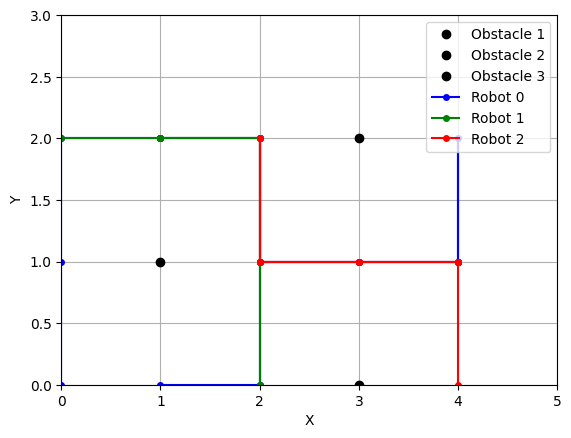

In [18]:
import matplotlib.pyplot as plt

def visualize_paths(grid, robot_positions, paths):
    # of the form (y,x) where y is coumn index and x is row index

    # Create a figure and axis for the plot
    fig, ax = plt.subplots()

    # Plot the grid
    count=0
    for i in range(len(grid)):
        for j in range(len(grid[0])):

            if grid[i][j] == 1:  # Obstacle
                count+=1
                ax.plot(j, i, 'ko', label=f'Obstacle {count}')  # Represent obstacles as black dots

    # Plot the paths of each robot
    colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k']
    for i in range(len(paths[0].robot_list)):  # Assuming all paths have the same number of robots
        x = [state.robot_list[i].position[1] for state in paths]
        print("x:\n", x)
        y = [state.robot_list[i].position[0] for state in paths]
        print("y:\n", y)
        ax.plot(x, y, linestyle='-', marker='o', markersize=4, label=f'Robot {i}', color=colors[i % len(colors)])

    # Set axis limits and labels
    ax.set_xlim(0, len(grid[0]))
    ax.set_ylim(0, len(grid))
    ax.set_xlabel('X')
    ax.set_ylabel('Y')

    # Add a legend
    ax.legend(loc='upper right')

    # Show the plot
    plt.gca()
    plt.grid(True)
    plt.show()

# Call the visualization function with your grid, robot positions, and paths
visualize_paths(grid, robot_positions, path)
